COPYRIGHT © 2018 Kiran Arun <kironni@gmail.com>

### Setup

In [1]:
# get dependencies
!rm -r Reinforcement_Learning-101-demo/
!git clone -b improvements https://github.com/KiranArun/Reinforcement_Learning-101-demo.git
from google.colab import auth
auth.authenticate_user()
!chmod +x Reinforcement_Learning-101-demo/scripts/setup.sh
!./Reinforcement_Learning-101-demo/scripts/setup.sh

Cloning into 'Reinforcement_Learning-101-demo'...
remote: Counting objects: 206, done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 206 (delta 20), reused 35 (delta 8), pack-reused 155
Receiving objects: 100% (206/206), 11.07 MiB | 24.76 MiB/s, done.
Resolving deltas: 100% (104/104), done.
Getting files from drive
Updating...


Installing cmake...


Installing ffmpeg...


Installing gym...
Installing opencv...


In [2]:
# run tensorboard
get_ipython().system_raw('tensorboard --logdir=/content/logdir/ --host=0.0.0.0 --port=6006 &')
get_ipython().system_raw('/content/ngrok http 6006 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print('Tensorboard Link:', json.load(sys.stdin)['tunnels'][0]['public_url'])"

Tensorboard Link: http://51d7172f.ngrok.io


# Reinforcement Learning

This is the second part to the reinforcement learning workshop.

In this notebook we will learn what A3C is, and how the model is trained.

#### Notebook information:
- this notebook will train an A3C model and save checkpoints and logs for tensorboard
- it will also go through what A3C is, and how it works in our case
- the code is based off https://github.com/awjuliani/DeepRL-Agents/blob/master/A3C-Doom.ipynb
- I also recommend the blog post corresponding to his code [Simple Reinforcement Learning with Tensorflow Part 8: Asynchronous Actor-Critic Agents (A3C)](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-8-asynchronous-actor-critic-agents-a3c-c88f72a5e9f2)

### Importing Libraries

In [0]:
import numpy as np                     # our linear algebra library
import matplotlib.pyplot as plt        # our plotting library
import tensorflow as tf                # our machine learning library

import gym                             # the environment library
import cv2                             # our image processing library
import scipy.signal                    # to discount our rewards over time
import threading                       # to run multiple workers at the same time

import time,os,sys
from IPython.display import HTML,Image # to show videos

import A3C_helper_functions as helper  # helper functions

### Asynchronous Advantage Actor-Critic (A3C)

**Asynchronous:** Working along side each other but not in time

- we have one global / master neural network
- we have multiple local / worker neural networks
- the workers play the game and calculate the gradients to use to update their weights (using gradient descent)
- the gradients are then applied to the master network
- the worker's variables are the assigned the values of the masters network

Asynchronous:


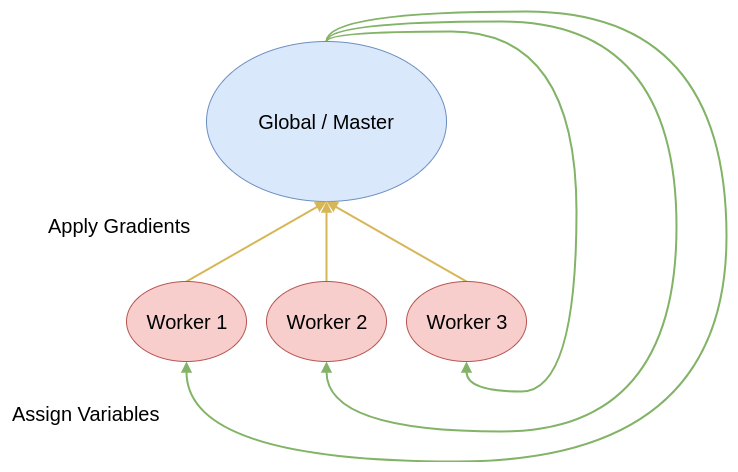

In [4]:
print('Asynchronous:')
Image('Reinforcement_Learning-101-demo/imgs/Worker_Global.png')

**Advantage:** How good or bad actions were in terms of the relative returns

- we compare how good actions were compared to the preferred choice
- the action probabilities are adjusted based on how the results turned out compared to what they would have given we always choose the most likely action

**Actor:** The part predicting the actions

- this is an output layer of the NN which outputs a discrete probability distribution on possible actions

**Critic:** The part which helps evaluate the actions (good or bad)

- this is an output layer of the NN which outputs the predicted value for the current state

### High Level Overview

Worker work process:

1. assign global variables to local variables
2. for `tmax` steps:
    - complete forward pass (inputting the environment state)
    - pick action at random using action probabilities (Boltzmann approach)
    - take step in environment using selected action
    - record state, reward, action taken and value in experience buffer
3. calculate target values
4. calculate advantage
5. calculate gradients
    - value loss = predicted values - target values
    - policy loss to increase/decrease action probabilities based on the advantage
6. apply gradients to global network

This diagram represents steps 1 and 2


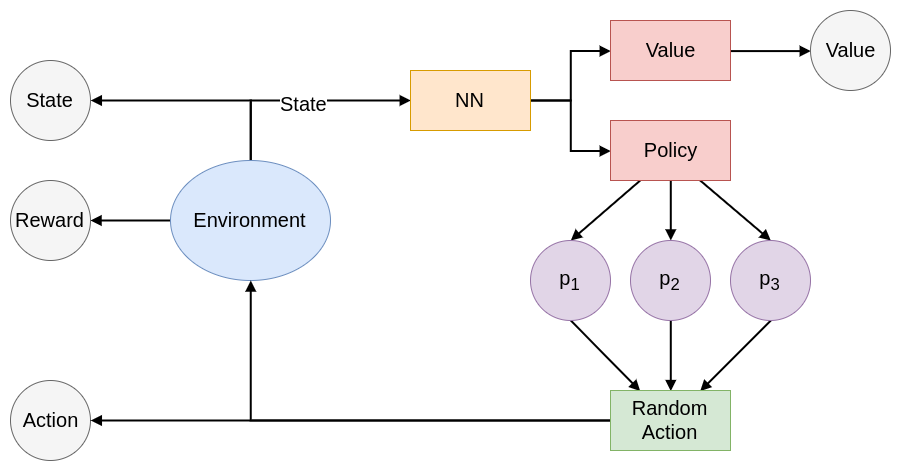

In [5]:
print('This diagram represents steps 1 and 2')
Image('Reinforcement_Learning-101-demo/imgs/Training_process.png')

### Settings and Hyperparameters

**gamma:** discount value $\gamma$

> $d(x,\gamma)_t = \sum_{k=0}\gamma^kx_{t+k}$

**state_size:** the input frame size (the image will be unstacked into a vector)

> $84\times84 \to 1\times7056$ 

**num_actions:** number of possible actions in environment

>  do nothing; shoot; move right; move left; move right and shoot; move left and shoot

**max_episodes:** number of episodes to train

> will stop training when first worker hits 10000 episodes (you can also stop manually)

**learning_rate:** learning rate

**num_workers:** number of worker networks

**start_checkpoint:** the model checkpoint to start training from

> the model must have the same network and workers

In [0]:
gamma = .99           # discount value over time
state_size = 84**2    # the size of our input image (unstacked)
num_actions = 6       # the number of possible actions to take in environment

max_episodes = 10000  # how many episodes for the first worker to reach to stop training
learning_rate = 2e-4  # learning rate
num_workers = 8       # number of workers
tmax = 50             # the number of time steps until an update is made
max_grad_norm = 40    # maximum gradient norm

# set directories
model_root_dir = '/content/'
model_logdir = os.path.join(model_root_dir,'logdir/')

# model checkpoint to start training from
# set to None if training from scratch
start_checkpoint = None

# our optimizer
trainer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=1e-2)

get the name for this specific training run (so it can be searched on tensorboard)

In [0]:
# get name of the log directory
run_logdir = helper.get_logdir(model_logdir,learning_rate,num_workers,tmax)

### Discount function

The further in the future the reward is, the less we want it to contribute to updating the current action.

$d(x,\gamma)_t = \sum_{k=0}\gamma^tx_{t+k}$

In [0]:
# discounting function used to calculate current + discounted future returns
def discount(x, gamma):
    return(scipy.signal.lfilter([1], [1, -gamma], x[::-1], axis=0)[::-1])

### Update worker function

This will set the variables from the worker/local network to the master/global networks variables.

**This isn't back propagation**, it's just setting the variables like `local_vars = global_vars`

In [0]:
# update worker using global network variables
def update_worker_network(from_scope, to_scope):
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, from_scope)
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, to_scope)
    ops_holder = []
    for from_var,to_var in zip(from_vars,to_vars):
        ops_holder.append(to_var.assign(from_var))
    return(ops_holder)

### The Network

**Inputs:** the input frame(s) (state)
- input the frames unstacked into 1 vector per image
- then put the images back into their image shape
- None is the batch size but we only feed 1 frame per forward pass in inference

---

**Conv net:** 2 convolutional layers
- to analyse the image
- activation: ELU (Exponential Linear Unit)

## $e(x,\alpha) =
    \begin{cases}
            x & \text{if } x \ge 0,\\
            \alpha(e^x-1) & \text{if } x < 0.
    \end{cases}$


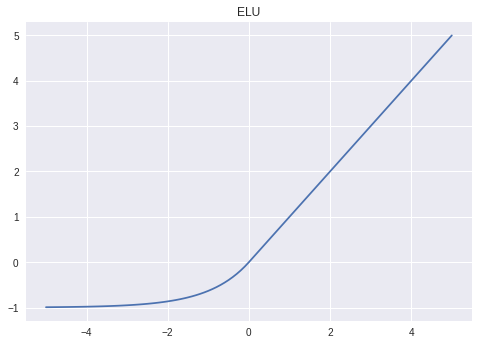

In [10]:
def elu(x,alpha):
    
    out = np.copy(x)
    out[x<0] = alpha*(np.exp(x[x<0]) - 1)
    
    return(out)

x = np.linspace(-5,5,101)
y = elu(x,alpha=1.0)

plt.title('ELU')
plt.plot(x,y)
plt.show()

---

**Fully Connected:** a single fully connected layer
- to finish analysing the image
- activation: ELU (Exponential Linear Unit)

---

**LSTM:** a Long Short Term Memory cell
- we input the output of fc1 and the lstm state
- the lstm cell will output an updated lstm state every forward pass, and we'll pass that in next step
- this will allow the neural net to make a decision based on not just the current input, but the history (the lstm state)
- this goes for all recurrent neural networks (lstm's are a subcatagory)

RNN/LSTM cell


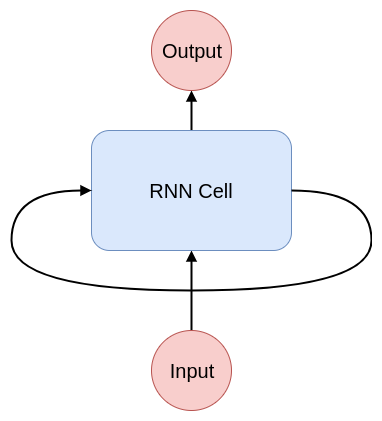

In [11]:
print('RNN/LSTM cell')
Image('Reinforcement_Learning-101-demo/imgs/RNN.png')

---

**Policy:** the fully connected output layer
- we use a final fully connected layer to out 6 probabilities
- the probability represents how good its corresponding action is
- we use softmax activation to convert raw outputs to probabilities

---

**Value:** another fully connected output layer
- this will predict the value of the current state
- this is the same as all discounted future rewards summed together

### Updating the Network

We will update the global network using the gradient from the local networks.

#### Loss functions:

**Value loss:** the difference between predicted value and the true value

Target values: $G_t = v_{t+K+1}+\sum_{k=0}^K\gamma^kr_{t+k}$

- with $v_t =$ the predicted value for time step $t$
- we only have the rewards for $K$ ($tmax$) time steps
- we **bootstrap** the predicted value after the last time step $v_{t+K+1}$
- this is the prediction of the sum of all rewards from $t+K+1$


Bootstrapping:


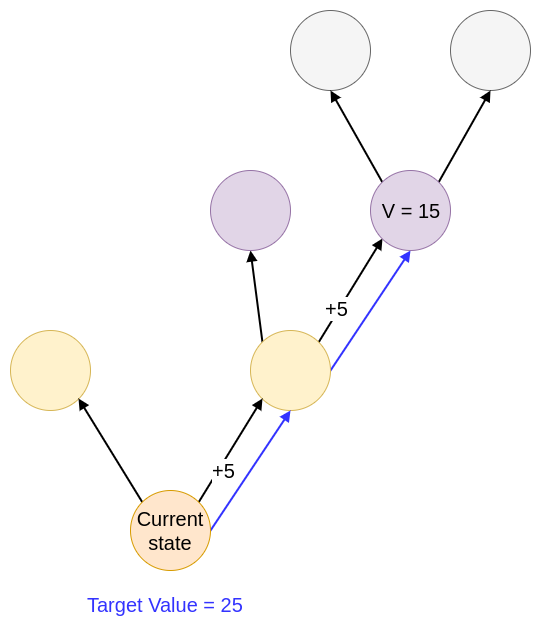

In [12]:
print('Bootstrapping:')
Image('Reinforcement_Learning-101-demo/imgs/Bootstrap_value.png')

### $L = \frac{1}{2}\sum_{k=0}^{K}(G_{t+k} - v_{t+k})^2$

- we take the squared difference and sum over the time steps
- we halve to remove an extra operation during calculating the gradients

---

**Policy loss:** will bias for or against action given advantage of action taken

Advantage: $a_t = \sum_{k=0}^K \gamma^k(r_{t+k} + \gamma v_{t+k+1} - v_{t+k})$

- $r_{t+k} + \gamma v_{t+k+1}$ = reward from step $t+k$ + predicted total future rewards given current policy from step $t+k+1$
- $v_{t+k}$ = predicted total future rewards given current policy from step $t+k$

This basically means:
> total rewards from choosing the action we took vs total rewards from choosing the action based on the current policy

- $a > 0$ means action taken was better than current policy
- $a < 0$ means action taken was worse than current policy
<br><br>

### $L = -\sum_{k=0}^K\ln(p_{t+k})a_{t+k}$

- with $p_t =$ action probability at time step $t$ 
- with $a_t =$ advantage as time step $t$
- we update the network so that $p_t$ is changed to make the loss less
- even though the advantage is dependant on the NN (through the value), we dont update the NN to affect the value as the advantage is an input (the operations to calculate the advantage are not in the TF graph)

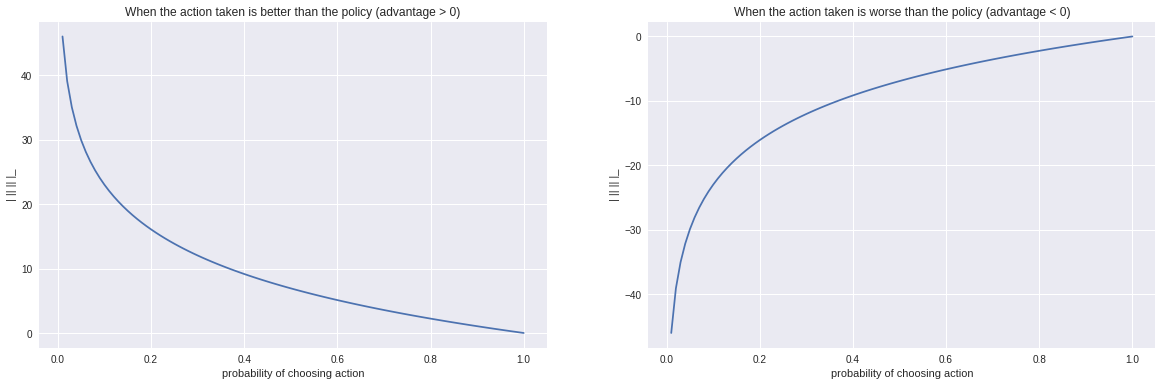

In [13]:
titles = ['When the action taken is better than the policy (advantage > 0)',
          'When the action taken is worse than the policy (advantage < 0)']
fig,ax = plt.subplots(1,2,figsize=(20,6))

def f(action_prob,advantage):
    return(- np.log(action_prob) * advantage)

adv_action_better = 10
adv_policy_better = -10

p = np.linspace(0.01,1,100)

ax[0].plot(p,f(p,adv_action_better))
ax[1].plot(p,f(p,adv_policy_better))

for i,axes in enumerate(ax):
    axes.set_xlabel('probability of choosing action')
    axes.set_ylabel('| || || |_')
    axes.set_title(titles[i])

plt.show()

---
    
**Entropy:** this will make the action probabilities more uniform, which increases exploration

## $L = - \sum_{t=0}^T P_t\ln(P_t)$

- with $p_t =$ policy outputs for timestep $t$

In [0]:
class AC_Network():
    def __init__(self, state_size, num_actions, scope, trainer):
        with tf.variable_scope(scope):
            
            # Inputs
            self.inputs = tf.placeholder(shape=[None, state_size], dtype=tf.float32)
            self.inputs_reshaped = tf.reshape(self.inputs, shape=[-1, 84, 84, 1])
            
            # Conv net - image analysis
            self.conv1 = tf.layers.conv2d(inputs=self.inputs_reshaped,
                                          filters=16,
                                          kernel_size=[8, 8],
                                          strides=[4, 4],
                                          activation=tf.nn.elu,
                                          padding='SAME')
            self.conv2 = tf.layers.conv2d(inputs=self.conv1,
                                          filters=32,
                                          kernel_size=[4, 4],
                                          strides=[2, 2],
                                          activation=tf.nn.elu,
                                          padding='SAME')
            
            # Fully connected - image analysis
            self.fc1 = tf.layers.dense(inputs=tf.layers.flatten(self.conv2),
                                       units=256,
                                       activation=tf.nn.elu)

            # LSTM - include information about the history in the predictions
            lstm_state_size = 256
            lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=lstm_state_size, state_is_tuple=True)
            
            # create initial state
            self.initial_state = (np.zeros([1,lstm_state_size]),np.zeros([1,lstm_state_size]))
            
            # create state placeholders
            c_input_state = tf.placeholder(shape=[1,lstm_state_size], dtype=tf.float32)
            h_input_state = tf.placeholder(shape=[1,lstm_state_size], dtype=tf.float32)
            self.input_state = tf.nn.rnn_cell.LSTMStateTuple(c_input_state,h_input_state)
            
            # reformat input data [batch_size, time_steps, features]
            # our batch size is always 1
            rnn_in = tf.expand_dims(self.fc1, [0])
            
            # define lstm
            # lstm state is the state to input next time step
            lstm_outputs, self.lstm_state = tf.nn.dynamic_rnn(cell=lstm_cell,
                                                              inputs=rnn_in,
                                                              initial_state=self.input_state,
                                                             )
            
            # reshape the outputs so that shape = [time_steps, lstm_state_size]
            # our batch size is always 1, so we can remove it
            rnn_out = tf.reshape(lstm_outputs, [-1, lstm_state_size])
            
                        
            # Policy - probabilities of each action
            self.policy = tf.layers.dense(inputs=rnn_out,
                                          units=num_actions,
                                          activation=tf.nn.softmax,
                                          bias_initializer=None)
            
            # Value - total discounted reward given current policy
            self.value = tf.layers.dense(inputs=rnn_out,
                                         units=1,
                                         activation=None,
                                         bias_initializer=None)
            
            
            
            # for all worker networks
            # this will update the global network using the current workers gradients
            if scope != 'global':
                
                
                # actions placeholder
                self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
                self.actions_onehot = tf.one_hot(self.actions, num_actions, dtype=tf.float32)
                
                # the total discounted rewards from current time step in current state
                self.target_values = tf.placeholder(shape=[None], dtype=tf.float32)
                
                # comparison between rewards from actions taken and predicted rewards given current policy
                self.advantages = tf.placeholder(shape=[None], dtype=tf.float32)
                
                # get probability values of actions
                self.responsible_outputs = tf.reduce_sum(self.policy * self.actions_onehot, [1])
                
                

                # Loss functions
                
                # Value loss - difference between predicted and true values
                self.value_loss = 0.5 * tf.reduce_sum(tf.square(self.target_values - tf.reshape(self.value, [-1])))
                
                # Policy loss - will increase / decrease action probability given the advantage
                self.policy_loss = -tf.reduce_sum(tf.log(self.responsible_outputs) * self.advantages)
                
                # Entropy - to make policy values more uniform to increase exploration
                self.entropy = - tf.reduce_sum(self.policy * tf.log(self.policy))
                
                # combine losses
                self.loss = 0.5 * self.value_loss + self.policy_loss - self.entropy * 0.01
                
                

                # get local variables
                local_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope)
                
                # calculate gradients of loss in terms of local variables
                self.gradients = tf.gradients(self.loss, local_vars)
                
                # clip gradients when norm > 50
                # this reduces the values so the norm = 50
                grads, self.grad_norms = tf.clip_by_global_norm(self.gradients, max_grad_norm)

                # get global variables and perform backpropagation on them
                global_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'global')
                self.apply_grads = trainer.apply_gradients(zip(grads,global_vars))

## Workers

**init** function:

1. define worker settings
2. create tensorboard summary writer
3. define local network
4. get ops to update local vars with global vars
5. create environment

---

**train** function:

1. input experience buffer (things from previous `tmax` steps)
2. get observations (states), actions taken, rewards and values for each time step
3. calculate target values $= v_{t+K+1}+\sum_{k=0}^K\gamma^kr_{t+k}$
4. calculate advantages $= \sum_{k=0}^K \gamma^k(r_{t+k} + \gamma v_{t+k+1} - v_{t+k})$
5. call **`apply_grads`** to update global network
6. get updated **`batch_lstm_states`** for next call of train function

---

**work** function:

1. initialize number of episodes local worker has played
2. while coordinator hasn't requested a stop
    3. update local network
    4. initialize stuff (experience buffer, done, environment, input state, lstm states)
    5. while episode is not done
        6. complete forward pass, inputting current state, outputting policy and value outputs
        7. choose action using boltzmann approach
        8. take step in environment
        9. process new frame
        10. add new experience to buffer and history
        11. set new state to current state
        12. if reached `tmax` steps since last update
            13. get value for current state
            14. call **`train`** function
            15. reset buffer
            16. update local network
    18. call **`train`** function with remaining buffer
    19. call **`end_training_episode`** to log, print and update everything
    20. if reached max episodes, request a stop

In [0]:
class Worker():
    def __init__(self, worker_number, state_size, num_actions, trainer, max_episodes):
        
        # 1 - define worker settings
        self.worker_name = "worker_" + str(worker_number)
        self.number = worker_number
        self.trainer = trainer
        self.max_episodes = max_episodes
        self.episodes_history = np.empty([0,2])
        
        # 2 - create tensorboard summary writer
        self.writer = tf.summary.FileWriter(run_logdir+'/'+self.worker_name)
        
        # 3 - define local network
        self.local_AC = AC_Network(state_size, num_actions, self.worker_name, trainer)
        
        # 4 - get ops to update local vars with global vars
        self.update_local_ops = update_worker_network('global', self.worker_name)
        
        # 5 - create environment
        self.env = gym.make('SpaceInvaders-v4')
        
        
    def train(self, rollout, sess, gamma, bootstrap_value):
        
        # 1 - input experience buffer (things from previous tmax steps)
        rollout = np.array(rollout)
        
        # 2 - get observations (states), actions taken, rewards and values for each time step
        observations = rollout[:,0]
        actions = rollout[:,1]
        rewards = rollout[:,2]
        values = rollout[:,5]
        
        # 3 - calculate target values
        # add the bootstrapped value to the end of the array of rewards
        rewards_with_bootstrap = np.asarray(rewards.tolist() + [bootstrap_value])
        # sum and discount each rewards with the their future rewards
        target_values = discount(rewards_with_bootstrap,gamma)[:-1]
        
        # 4 - calculate advantages
        # add the bootstrapped value to the end of the array of values
        values_with_bootstrap = np.asarray(values.tolist() + [bootstrap_value])
        # calculate rewards + (gamma * value(t + 1)) - value(t)
        advantages = rewards + gamma * values_with_bootstrap[1:] - values_with_bootstrap[:-1]
        # sum for each future dicounted advantage
        advantages = discount(advantages, gamma)
        
        # create inputs dictionary for steps 5 and 6
        feed_dict = {self.local_AC.target_values:target_values,
                     self.local_AC.inputs:np.vstack(observations),
                     self.local_AC.actions:actions,
                     self.local_AC.advantages:advantages,
                     self.local_AC.input_state[0]:self.batch_lstm_states[0],
                     self.local_AC.input_state[1]:self.batch_lstm_states[1]}
        
        # 5 - call apply_grads to update global network
        # 6 - get updated batch_lstm_states for next call of train function
        self.batch_lstm_states,_ = sess.run([self.local_AC.lstm_state,
                                             self.local_AC.apply_grads],
                                            feed_dict=feed_dict)
        
    def work(self, gamma, sess, coord, saver):
        
        # 1 - initialize number of episodes local worker has played
        worker_episode_count = 0
        
        print ("Starting " + str(self.worker_name))
        
        # 2 - while coordinator hasn't requested a stop
        while not coord.should_stop():
            
            # 1 - update local network
            sess.run(self.update_local_ops)
            
            # 2 - initialize stuff (experience buffer, done, environment, input state, lstm states)
            # buffer to use in the train function
            episode_buffer = []
            # done, when True, the episode is done
            d = False
            # episode history to see show stats at the end of episode
            episode_history = []
            # reset and get first frame of environment
            init_frame = self.env.reset()
            # process the frame (this is the current processed frame)
            processed_s = helper.preprocess_frame(init_frame).reshape(1,-1)
            # set s to the processed frame (this is the current state)
            s = processed_s
            # create lstm states for experience loop
            self.current_lstm_states = self.local_AC.initial_state
            # create lstm states for train function
            self.batch_lstm_states = self.local_AC.initial_state

            # 3 - while episode is not done
            while d == False:
                
                # 1 - complete forward pass, inputting current state, outputting policy and value outputs
                a_dist, v, self.current_lstm_states = sess.run([self.local_AC.policy,
                                                                self.local_AC.value,
                                                                self.local_AC.lstm_state],
                                                               feed_dict={self.local_AC.inputs:s,
                                                                          self.local_AC.input_state[0]:self.current_lstm_states[0],
                                                                          self.local_AC.input_state[1]:self.current_lstm_states[1]})
                
                # 2 - choose action using boltzmann approach
                a = np.random.choice(a_dist[0],p=a_dist[0])
                a = np.argmax(a_dist == a)
                
                # 3 - take step in environment
                unprocessed_s1, r, d, info = self.env.step(a)

                # 4 - process new frame
                if d == False:
                    # get new processed frame
                    processed_s1 = helper.preprocess_frame(unprocessed_s1).reshape(1,-1)
                    # create new processed state
                    s1 = np.maximum(processed_s,processed_s1)
                else:
                    # if the game is over, set the new frame to the input frame
                    s1 = s
                    
                # 5 - add new experience to buffer and history
                episode_buffer.append([s, a, r, s1, d, v[0,0]])
                episode_history += [[s, a, r, s1, d]]
                
                # 6 - set new state to current state
                s = s1
                processed_s = processed_s1
                
                # 7 - if reached tmax steps since last update
                if len(episode_buffer) == tmax and d != True:
                    
                    # 1 - get value for current state
                    v1 = sess.run(self.local_AC.value,
                                  feed_dict={self.local_AC.inputs:s,
                                             self.local_AC.input_state[0]:self.current_lstm_states[0],
                                             self.local_AC.input_state[1]:self.current_lstm_states[1]})[0,0]
                    
                    # 2 - call train function
                    self.train(episode_buffer, sess, gamma, v1)
                    
                    # 3 - reset buffer
                    episode_buffer = []
                    
                    # 4 - update local network
                    sess.run(self.update_local_ops)

                if d == True:
                    break
                    
            # 4 - call train function with remaining buffer
            if len(episode_buffer) != 0:
                self.train(episode_buffer, sess, gamma, 0.0)

                
            # 5 - call end_training_episode to log, print and update everything
            self.episodes_history,worker_episode_count = helper.end_training_episode(episode_history,
                                                                                     self.episodes_history,
                                                                                     worker_episode_count,
                                                                                     self.worker_name,
                                                                                     saver,
                                                                                     sess,
                                                                                     run_logdir,
                                                                                     self.writer)
            
            # 6 - if reached max episodes, request a stop
            if worker_episode_count == self.max_episodes:
                print('stopping training,', self.worker_name, 'has reached episode', worker_episode_count)
                coord.request_stop()

In [0]:
# reset tensorflow graph
tf.reset_default_graph()

## Creating global network and workers

In [0]:
# create global network
master_network = AC_Network(state_size, num_actions, 'global', None)
    
workers = []
# create list of workers
for i in range(num_workers):
    workers.append(Worker(i, state_size, num_actions, trainer, max_episodes))

# define summary writer for main graph
main_writer = tf.summary.FileWriter(run_logdir+'/main')

## Initailizing things

- Create Tensorflow Session
- Create Tensorflow coordinator to handle the threads
- Create Tensorflow saver to save open/save checkpoints
- Restore model checkpoint if set to do so
- Write the session to tensorboard

In [0]:
# setup tensorflow
sess = tf.InteractiveSession()               # session

coord = tf.train.Coordinator()               # coordinator for threads
saver = tf.train.Saver(max_to_keep=None)     # model saver

sess.run(tf.global_variables_initializer())  # initialize variables

if start_checkpoint != None:
    saver.restore(sess, start_checkpoint)    # choose starting checkpoint
    
main_writer.add_graph(sess.graph)            # write graph to tensorboard

## Training

- Start workers
- Every few minutes, play a test game with global network and log to tensorboard
- Save model after training has finnished

In [0]:
worker_threads = []
tests = np.empty([0,2])

# start workers
for worker in workers:
    worker_work = lambda: worker.work(gamma, sess, coord, saver)
    t = threading.Thread(target=(worker_work))
    t.start()
    worker_threads.append(t)
    time.sleep(0.5)

# start tests with master network
n = 0
while coord.should_stop() != True:
    tests = np.append(tests, np.array(helper.test(sess,master_network)).reshape(1,2),axis=0)
    summary = tf.Summary()
    summary.value.add(tag='test_episode_steps',simple_value=int(tests[-1,0]))
    summary.value.add(tag='test_episode_reward',simple_value=int(tests[-1,1]))
    main_writer.add_summary(summary, n)
    main_writer.flush()
    n += 1
    time.sleep(180)
    
# stop and save when threads have all stopped
coord.join(worker_threads)
print('Saving final model...')
saver.save(sess, os.path.join(run_logdir, "final_model.ckpt"))

Starting worker_0
Starting worker_1
Starting worker_2
Starting worker_3
Starting worker_4
Starting worker_5
Starting worker_6
Starting worker_7
worker_4 :  episode: 0 reward: 120.0 actions: [ 1.  0.  2.  0. 96.  1.]
worker_1 :  episode: 0 reward: 340.0 actions: [ 2.  1.  4.  1. 89.  3.]
worker_7 :  episode: 0 reward: 355.0 actions: [ 3.  5.  5.  2. 83.  3.]


If you stopped training before letting it finnish, this will:
- check for final saved model
- if it doesnt exist:
    - stop threads
    - save final model

In [19]:
# if stopped before it saves and stops threads, do this
if os.path.exists(os.path.join(run_logdir,"final_model.ckpt.index")) != True:
    coord.request_stop()
    coord.join(worker_threads)
    print('Saving final model...')
    saver.save(sess, os.path.join(run_logdir, "final_model.ckpt"))

Saving final model...
INFO:tensorflow:/content/logdir/run_02-lr_0.0002-nw_8-tmax_50/final_model.ckpt is not in all_model_checkpoint_paths. Manually adding it.


## Play and display test game

640 framesSteps: 654 Reward: 105.0


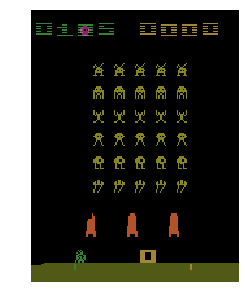

In [20]:
# test game
frames = helper.display_test(sess,master_network)
anim = helper.create_gameplay_video(frames,figsize=(5,5),save=False)
HTML(anim.to_jshtml())